<a href="https://colab.research.google.com/github/laurenneal/capstone-visual-neuroscience/blob/Dylan/get_results_and_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and test visualizations

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data from our seeded CNMF extraction is saved to te Results folder in h5 files using the naming convention of the movie stack they were extracted from.

In each file are three sections:

stack_name: the name of the movie stack the results were extracted from <br>
temporal: a (roi's) by (frames) matrix of fluorescence values for each roi<br>
spatial: a (rois) by (pixels) matrix of spatial footprints


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
f_name = '/content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Results/EXAMPLE_210728_0_1_stackRaw_mc_tm2_tm9_syt_result.h5'

#read file in using hdf5 structure
h = h5py.File(f_name,'r')


In [5]:
#list the three main folders
list(h.keys())

['spatial', 'stack_name', 'temporal']

In [8]:
# stack of each roi's footprints - we'll use each of these
bwLabelStack = h['spatial']

bwLabelStack.shape

(11, 32768)

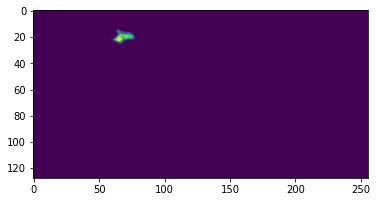

In [9]:
#plot the first roi
dims = [128, 256]
#save to variable
spatial = bwLabelStack[0][:]
plt.imshow(np.reshape(spatial, dims, order="F"))

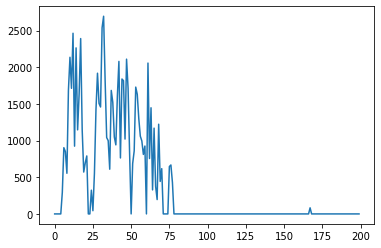

In [10]:
#visualize temporal traces - first 200 frames of the first roi
temporal = h['temporal'][0][0:200]
plt.plot(temporal)

# Extract features from each roi in the file

In [64]:
#IMPORTANT
#Set the time period in frames that we want to consider here
#If 1, then we're doing no temporal collapsing, just taking the raw fluorescence value at each frame
#if >1, then we return the mean, min, max fluorescence over chunks of that length

temporal_period_length = 20 #for example, 1 second

#imports
from scipy import ndimage
!pip install scikit-image
from skimage import measure
import skimage
import pandas as pd
from tqdm import notebook
from more_itertools import sliced

#every roi will have the same stack name, so declare it here
stack_name = h['stack_name'][()].decode("utf-8")

In [82]:
#set up different dataframes depending on if we're collpsing temporal features or not
if temporal_period_length == 1:

  roi_features = pd.DataFrame(columns =['roi_ID',
                                      'area',
                                      'center_of_mass_row',
                                      'center_of_mass_column',
                                      'fluorescence'])
  
else:
  roi_features = pd.DataFrame(columns =['roi_ID',
                                    'area',
                                    'center_of_mass_row',
                                    'center_of_mass_column',
                                    'mean_fluorescence',
                                    'min_fluorescence',
                                    'max_fluorescence'])
  
#loop through rois and extract features - these have not been validated to be calculated correctly
for x in notebook.tqdm(range(len(bwLabelStack))):

  spatial = bwLabelStack[x] #spatial footprint of the x'th roi
  temporal = h['temporal'][x]
  roi_ID = stack_name + '_' + str(x)
  #calculate spatial measures
  area = np.sum(spatial)
  dims = [128,256]
  spatial_img = np.reshape(spatial, dims, order="F")
  center_of_mass_row, center_of_mass_column = ndimage.center_of_mass(spatial_img)
  
  #If one sample is one frame, no temporal slicing necessary
  if temporal_period_length == 1:

    #to loop through all frames, swap the number for len(temporal)
    for frame in notebook.tqdm(range(200)):

      fluorescence = temporal[frame] #loop through frames

      roi_features = roi_features.append({'roi_ID': roi_ID,
                                          'area': area,
                                          'center_of_mass_row': center_of_mass_row,
                                          'center_of_mass_column': center_of_mass_column,
                                          'fluorescence': fluorescence}, ignore_index=True)
      
  else:

    #list of lists containing the sliced up fluorescence values, one chunk has the length set in temporal_period_length
    temporal_slices = list(sliced(temporal, temporal_period_length))

    #loop through slices and extract collapsed temporal features for each slice
    for temporal_slice in notebook.tqdm(range(len(temporal_slices))):

      if len(temporal_slices[temporal_slice]) == temporal_period_length:

        mean_fluorescence = np.mean(temporal_slices[temporal_slice]) #loop through frames
        min_fluorescence = np.min(temporal_slices[temporal_slice])
        max_fluorescence = np.max(temporal_slices[temporal_slice])

        roi_features = roi_features.append({'roi_ID': roi_ID,
                                            'area': area,
                                            'center_of_mass_row': center_of_mass_row,
                                            'center_of_mass_column': center_of_mass_column,
                                            'mean_fluorescence': mean_fluorescence,
                                            'min_fluorescence': min_fluorescence,
                                            'max_fluorescence': max_fluorescence}, ignore_index=True)


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

In [83]:
roi_features.sample(50)

,roi_ID,area,center_of_mass_row,center_of_mass_column,mean_fluorescence,min_fluorescence,max_fluorescence
2597,EXAMPLE_210728_0_1_stackRaw_mc_tm2_tm9_syt_9,6.170356,91.439936,115.654249,0.000000,0.000000,0.000000
1991,EXAMPLE_210728_0_1_stackRaw_mc_tm2_tm9_syt_7,4.940403,72.574353,96.850190,395.103293,0.000000,1940.981323
1986,EXAMPLE_210728_0_1_stackRaw_mc_tm2_tm9_syt_7,4.940403,72.574353,96.850190,437.938335,0.000000,3016.142194
2898,EXAMPLE_210728_0_1_stackRaw_mc_tm2_tm9_syt_10,9.229529,116.101015,107.088368,18.968019,0.000000,312.461906
657,EXAMPLE_210728_0_1_stackRaw_mc_tm2_tm9_syt_2,9.609274,28.200523,75.092982,0.000000,0.000000,0.000000
2946,EXAMPLE_210728_0_1_stackRaw_mc_tm2_tm9_syt_10,9.229529,116.101015,107.088368,5674.424637,3634.614817,7492.051938
2451,EXAMPLE_210728_0_1_stackRaw_mc_tm2_tm9_syt_8,7.470539,78.201955,93.688335,163.130287,0.000000,1158.390054
910,EXAMPLE_210728_0_1_stackRaw_mc_tm2_tm9_syt_3,10.333148,34.857062,82.903911,1201.546711,0.000000,6439.406581
1620,EXAMPLE_210728_0_1_stackRaw_mc_tm2_tm9_syt_5,8.658547,57.162998,90.061660,167.667530,0.000000,764.651645
744,EXAMPLE_210728_0_1_stackRaw_mc_tm2_tm9_syt_2,9.609274,28.200523,75.092982,915.835422,0.000000,2395.372397
